In [288]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import sys
from sklearn.feature_extraction.text import TfidfVectorizer

sys.path.append("../")

In [289]:
train_df = pd.read_csv(
    "../input/train.csv",
    usecols=[
        "id",
        "comment_text",
        "toxic",
        "severe_toxic",
        "obscene",
        "threat",
        "insult",
        "identity_hate",
    ],
)
test_df = pd.read_csv("../input/test.csv", usecols=["id", "comment_text"])

# Rename columns in the DataFrame
columns_base = ["ID", "Comment_Text"]
columns_type = [
    "Is_Toxic",
    "Is_Severe_Toxic",
    "Is_Obscene",
    "Is_Threat",
    "Is_Insult",
    "Is_Identity_Hate",
]
columns_all = columns_base + columns_type
train_df.columns = columns_all
test_df.columns = columns_base

In [290]:
# CONSTANTS
LOGISTIC_REGRESSION = "LogisticRegression"
RANDOM_FORREST = "RandomForrest"
MULTINOMIAL_NB = "MultinomialNB"
MODEL = LOGISTIC_REGRESSION
NUM_OF_FEATURES = 5_000
GOOD_COMMENTS_RATIO = 3
RUN_FULL_PCA = False

# EDA

In [291]:
train_df.head(5)

,ID,Comment_Text,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [292]:
type_count = train_df[columns_type].sum()
total_samples = len(train_df)
type_percentage = (type_count / total_samples) * 100
print("Size of train dataset:")
print(train_df.shape)

rows_with_all_zeros = train_df[(train_df[columns_type] == 0).all(axis=1)]
print("\nCount of rows with all 0 types:", len(rows_with_all_zeros))

percentage_nonzero_types = 1 - (len(rows_with_all_zeros) / len(train_df))
print(
    "\nPercentage of rows with at least one non-zero type: {:.2%}".format(
        percentage_nonzero_types
    )
)

class_summary = pd.DataFrame({"Count": type_count, "Percentage": type_percentage})
class_summary["Percentage"] = class_summary["Percentage"].map("{:.2f}%".format)
print("\nSum for each type with added value, percentage and labels:")
print(class_summary)

Size of train dataset:
(159571, 8)

Count of rows with all 0 types: 143346

Percentage of rows with at least one non-zero type: 10.17%

Sum for each type with added value, percentage and labels:
                  Count Percentage
Is_Toxic          15294      9.58%
Is_Severe_Toxic    1595      1.00%
Is_Obscene         8449      5.29%
Is_Threat           478      0.30%
Is_Insult          7877      4.94%
Is_Identity_Hate   1405      0.88%


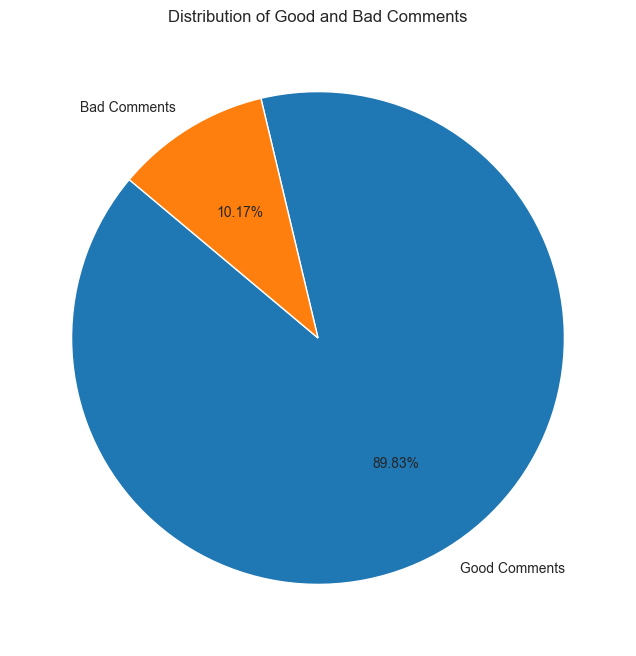

In [293]:
comments_category = pd.DataFrame(
    {
        "Category": ["Good Comments", "Bad Comments"],
        "Count": [len(rows_with_all_zeros), len(train_df) - len(rows_with_all_zeros)],
    }
)

plt.figure(figsize=(8, 8))
plt.pie(
    comments_category["Count"],
    labels=comments_category["Category"],
    autopct="%1.2f%%",
    startangle=140,
)
plt.title("Distribution of Good and Bad Comments")
plt.show()

In [294]:
selected_rows_df = pd.DataFrame(columns=columns_all)
type_counts = {}
for text_type in columns_type:
    mask = (train_df[text_type] == 1) & (train_df[columns_type].sum(axis=1) == 1)
    count = mask.sum()
    type_counts[text_type] = count
    first_appearance = train_df[mask].head(1)
    selected_rows_df = pd.concat(
        [selected_rows_df, first_appearance], ignore_index=True
    )

print("Count of comments where only a specific type has 1 and others are 0:")
for text_type, count in type_counts.items():
    print(f"{text_type}: {count}")

Count of comments where only a specific type has 1 and others are 0:
Is_Toxic: 5666
Is_Severe_Toxic: 0
Is_Obscene: 317
Is_Threat: 22
Is_Insult: 301
Is_Identity_Hate: 54


In [295]:
selected_rows_df = pd.DataFrame(columns=columns_all)
for text_type in columns_type:
    mask = (train_df[text_type] == 1) & (train_df[columns_type].sum(axis=1) == 1)
    first_appearance = train_df[mask].head(1)
    selected_rows_df = pd.concat(
        [selected_rows_df, first_appearance], ignore_index=True
    )

In [296]:
with pd.option_context("display.max_colwidth", None):
    display(selected_rows_df)

,ID,Comment_Text,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate
0,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
1,01625cc84c6ef15b,"How do you know he is dead. Its just his plane that crashed. Jeezz, quit busting his nuts, folks.",0,0,1,0,0,0
2,09eb7d87b8c24ca5,"Please stop. If you continue to ignore our policies by introducing inappropriate pages to Wikipedia, you will be blocked.",0,0,0,1,0,0
3,006d11791d76b9f3,"REPLY ABOVE:\nThat was me, loser. The UN defines Vietnam to be part of Southeast Asia. And far as I know Vietnam is part of ASEAN, and used to be part of French Indochina with Laos and all those shit countries Anyway your culture has always been more influenced by SEA than Han Chinese (as in proper Yangtze Han Chinese, not the fringe indigenous tribes in Guangzhou/Guangxi). \n\nJust admit that you vietnamese are all a bunch of wannabe crap people. ALL the east asian people I've spoken to thinks of Vietnam as a very integral part of SEA, and we all think you're backward, dirty and speak in a horrible swearing language. Doesn't matter what crap you spout on Wikipedia, won't change the way people in the real world think.",0,0,0,0,1,0
4,09b51ed1ee5e29a1,"Mate, sound like you are jewish\n\nGayness is in the air",0,0,0,0,0,1


In [297]:
sample_stats = train_df.copy()

# Calculate and display number of words, characters, symbols, and capital letters separately for the original comment text
columns_stats = ["num_words", "num_chars", "num_symbols", "num_capital_letters"]
sample_stats["num_words"] = sample_stats["Comment_Text"].apply(
    lambda x: len(str(x).split())
)
sample_stats["num_chars"] = sample_stats["Comment_Text"].apply(len)
sample_stats["num_symbols"] = sample_stats["Comment_Text"].apply(
    lambda x: len(
        [char for char in str(x) if not char.isalnum() and not char.isspace()]
    )
)
sample_stats["num_capital_letters"] = sample_stats["Comment_Text"].apply(
    lambda x: sum(1 for char in str(x) if char.isupper())
)

In [298]:
def show_stats(columns_name):
    mean = np.mean(sample_stats[columns_name])
    median = np.median(sample_stats[columns_name])
    std_dev = np.std(sample_stats[columns_name])
    min_value = np.min(sample_stats[columns_name])
    max_value = np.max(sample_stats[columns_name])

    print("Mean:", mean)
    print("Median:", median)
    print("Standard Deviation:", std_dev)
    print("Minimum Value:", min_value)
    print("Maximum Value:", max_value)

Number of Words stats:

Mean: 67.27352714465661
Median: 36.0
Standard Deviation: 99.23039126279367
Minimum Value: 1
Maximum Value: 1411


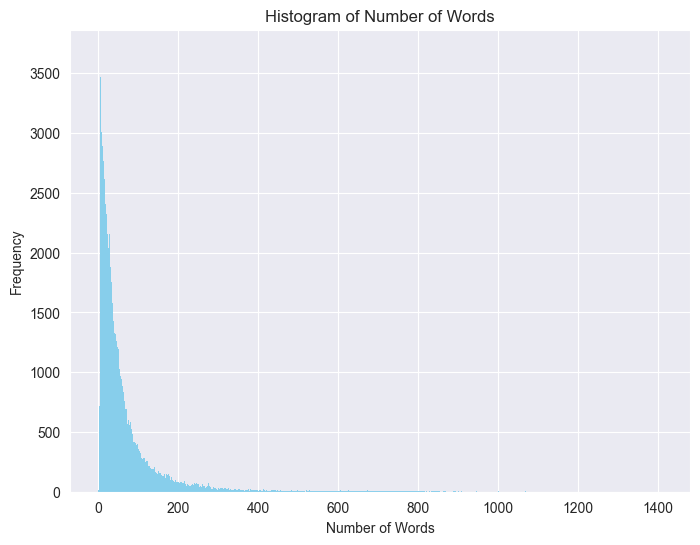

In [299]:
# Create and display a histogram for the number of words
plt.figure(figsize=(8, 6))
plt.hist(
    sample_stats["num_words"],
    bins=range(min(sample_stats["num_words"]), max(sample_stats["num_words"]) + 1),
    edgecolor="black",
    color="skyblue",
    lw=0,
)
plt.title("Histogram of Number of Words")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

print("Number of Words stats:\n")
show_stats("num_words")

plt.show()

Number of Characters stats:

Mean: 394.0732213246768
Median: 205.0
Standard Deviation: 590.7184309382144
Minimum Value: 6
Maximum Value: 5000


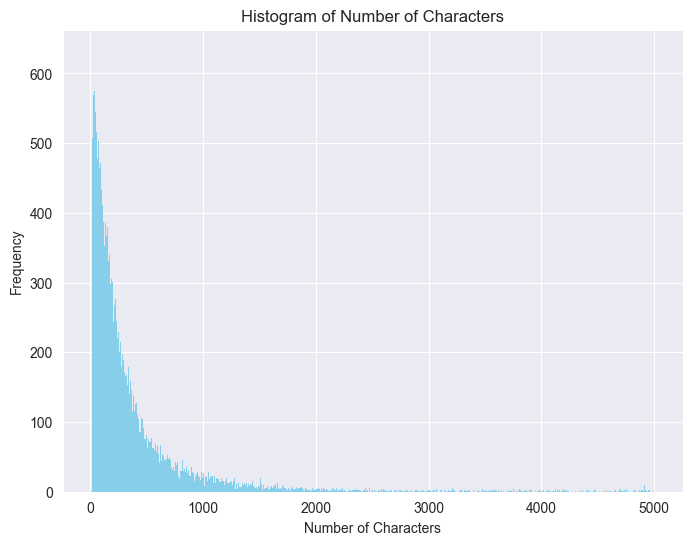

In [300]:
# Create and display a histogram for the number of characters
plt.figure(figsize=(8, 6))
plt.hist(
    sample_stats["num_chars"],
    bins=range(min(sample_stats["num_chars"]), max(sample_stats["num_chars"]) + 1),
    edgecolor="black",
    color="skyblue",
    lw=0,
)
plt.title("Histogram of Number of Characters")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")

print("Number of Characters stats:\n")
show_stats("num_chars")

plt.show()

Number of Symbols stats:

Mean: 16.105940302435908
Median: 8.0
Standard Deviation: 36.997153498413226
Minimum Value: 0
Maximum Value: 4942


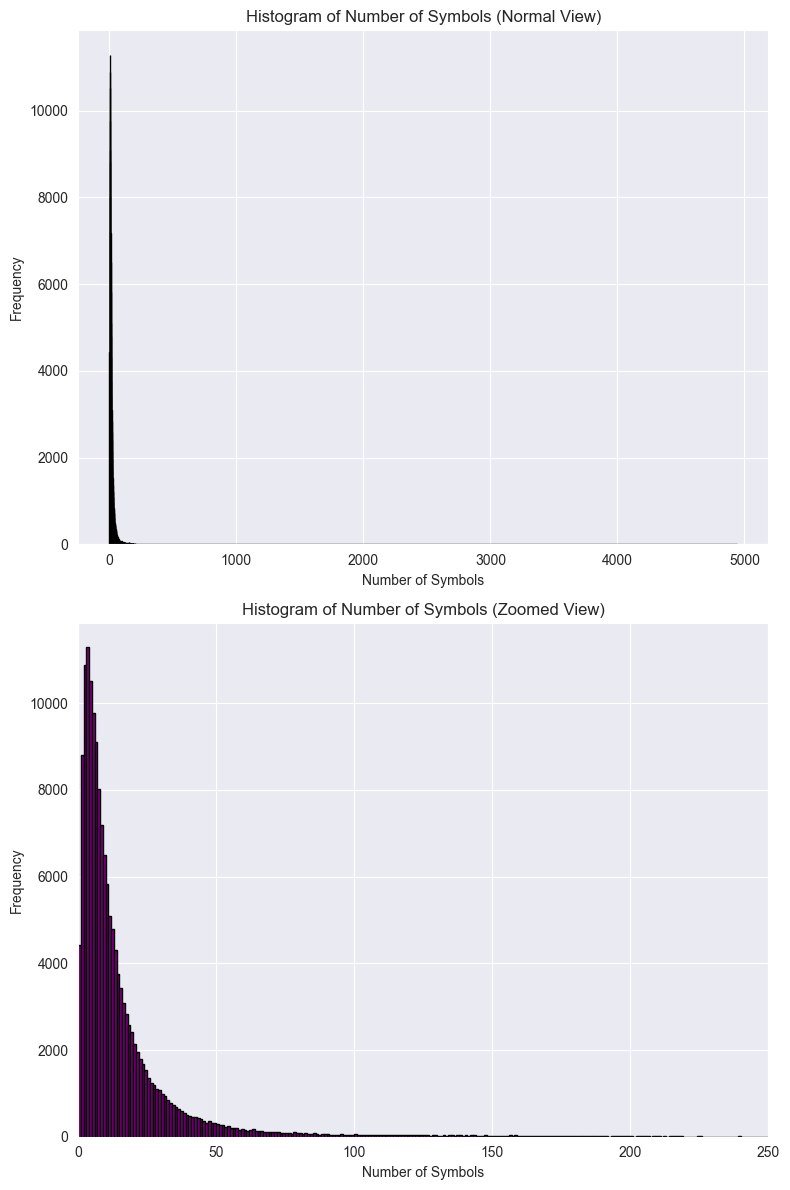

In [301]:
# Create and display a histogram for the number of symbols
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Plot 1: Normal view
axes[0].hist(
    sample_stats["num_symbols"],
    bins=range(min(sample_stats["num_symbols"]), max(sample_stats["num_symbols"]) + 1),
    color="purple",
    edgecolor="black",
)
axes[0].set_title("Histogram of Number of Symbols (Normal View)")
axes[0].set_xlabel("Number of Symbols")
axes[0].set_ylabel("Frequency")

# Plot 2: Zoomed-in x-axis
axes[1].hist(
    sample_stats["num_symbols"],
    bins=range(min(sample_stats["num_symbols"]), max(sample_stats["num_symbols"]) + 1),
    color="purple",
    edgecolor="black",
)
axes[1].set_title("Histogram of Number of Symbols (Zoomed View)")
axes[1].set_xlabel("Number of Symbols")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(left=0, right=250)

print("Number of Symbols stats:\n")
show_stats("num_symbols")

plt.tight_layout()
plt.show()

Number of Capital Letters stats:

Mean: 17.159628002581922
Median: 7.0
Standard Deviation: 96.52780102704632
Minimum Value: 0
Maximum Value: 4960


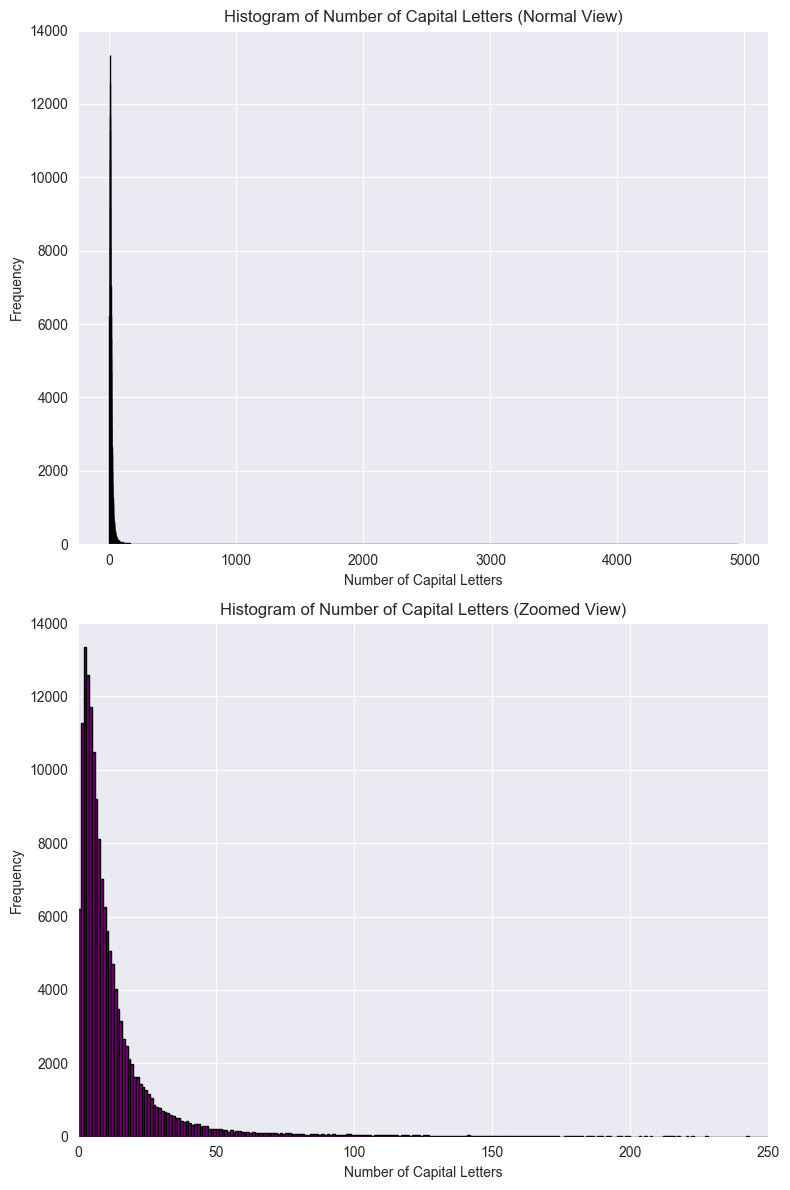

In [302]:
# Create and display a histogram for the number of capital letters
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Plot 1: Normal view
axes[0].hist(
    sample_stats["num_capital_letters"],
    bins=range(min(sample_stats["num_symbols"]), max(sample_stats["num_symbols"]) + 1),
    color="purple",
    edgecolor="black",
)
axes[0].set_title("Histogram of Number of Capital Letters (Normal View)")
axes[0].set_xlabel("Number of Capital Letters")
axes[0].set_ylabel("Frequency")

# Plot 2: Zoomed-in x-axis
axes[1].hist(
    sample_stats["num_capital_letters"],
    bins=range(min(sample_stats["num_symbols"]), max(sample_stats["num_symbols"]) + 1),
    color="purple",
    edgecolor="black",
)
axes[1].set_title("Histogram of Number of Capital Letters (Zoomed View)")
axes[1].set_xlabel("Number of Capital Letters")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(left=0, right=250)

print("Number of Capital Letters stats:\n")
show_stats("num_capital_letters")

plt.tight_layout()
plt.show()

In [303]:
correlation_matrix = sample_stats[columns_type + columns_stats].corr()
correlation_matrix

,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate,num_words,num_chars,num_symbols,num_capital_letters
Is_Toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,-0.052444,-0.054470,-0.014582,0.091175
Is_Severe_Toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,0.008452,0.010131,0.037277,0.143410
Is_Obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,-0.042207,-0.042945,-0.014460,0.081691
Is_Threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,-0.006688,-0.008011,0.017213,0.033581
Is_Insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,-0.043642,-0.045052,-0.016584,0.075945
Is_Identity_Hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,-0.014493,-0.013647,-0.010848,0.053576
num_words,-0.052444,0.008452,-0.042207,-0.006688,-0.043642,-0.014493,1.000000,0.987839,0.575850,0.358341
num_chars,-0.054470,0.010131,-0.042945,-0.008011,-0.045052,-0.013647,0.987839,1.000000,0.629901,0.370550
num_symbols,-0.014582,0.037277,-0.014460,0.017213,-0.016584,-0.010848,0.575850,0.629901,1.000000,0.254003
num_capital_letters,0.091175,0.143410,0.081691,0.033581,0.075945,0.053576,0.358341,0.370550,0.254003,1.000000


In [304]:
sample_stats.sort_values(by="num_capital_letters", ascending=False).head(10)

,ID,Comment_Text,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate,num_words,num_chars,num_symbols,num_capital_letters
11796,1f31848ca28571da,==U R GAY== \n\nFUCKFUCKFUCKFUCKFUCKFUCKFUCKFU...,1,1,1,0,1,1,4,4969,4,4960
40851,6d063d8888c30ce7,Discussion destroying CRAP topic \n\nIt seems ...,1,0,0,0,0,0,52,4957,5,4717
6201,1091689382892a88,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,1,1,1,0,0,0,455,5000,0,4546
1876,0512b588a4b80e45,YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!...,1,0,1,0,1,1,96,4897,200,4522
128196,ad9af3006c7cbbe6,toolLONG LIVE ANONYMOUS PHILIPPINESLONG LIVE A...,0,0,0,0,0,0,484,4999,0,4512
35316,5e50cf56f160bda3,MarxismLONG LIVE ANONYMOUS PHILIPPINESLONG LIV...,0,0,0,0,0,0,484,5000,0,4511
121718,8b31f2d7d6025482,BUTTSECKS BUTTSECKS BUTTSECKS BUTTSECKS BUTTSE...,1,0,1,0,0,0,497,5000,0,4473
82636,dd0bd64b02c550af,"MUAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA, YOU C...",1,0,0,0,0,0,433,5000,144,4424
63687,aa699b024b46da4a,do you know what i say gas the mother fucking ...,1,1,1,0,0,1,608,4969,0,4320
42061,70368dd072aebb42,WANKER WANKER WANKER WANKER WANKER WANKER WANK...,1,0,0,0,0,0,715,5000,0,4286


In [305]:
sample_stats.sort_values(by="num_symbols", ascending=False).head(10)

,ID,Comment_Text,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate,num_words,num_chars,num_symbols,num_capital_letters
75499,c9f42b4dedc3cbf0,YOU!\nYou blocked me worm why!!!!!!!!!!!!!!!!!...,1,0,0,0,0,0,7,4970,4942,4
135857,d6ab1b62b0d08a2e,why don't you suck my ass until your lips blee...,1,1,1,0,1,0,30,4969,4819,80
52727,8cee04ab6861a675,I'M GONNA KILL YOU!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1,1,0,1,0,0,100,4969,4518,350
40485,6c0b6e54d0b2ca24,LUNCHABLES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1,0,0,0,0,0,164,4681,3260,530
86529,e77118621b13b43f,Wikipedia tEh Free Enyclopedia!!!!!!!!!!!!!!!!...,0,0,0,0,0,0,280,5000,2762,280
31042,52791a0d0a4ba563,Is weezer okay?Is weezer okay?Is weezer okay?I...,0,0,0,0,0,0,311,4384,2210,155
28855,4c7963eaf9697d35,JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST...,1,1,0,1,0,0,626,5000,1872,2347
112812,5b7bd7b09b7ba86c,IDIOT/////IDIOT/////IDIOT/////IDIOT/////IDIOT/...,1,1,1,0,1,0,5,2680,1330,1345
67761,b54951588a1207ea,"This signature from, (Mr. Geroge W. Bush)\n\n...",0,0,0,0,0,0,185,2357,1269,59
139496,eaac752ae552d44a,'''[[\n== [[\n[[== THIS SITE IS STUPID DON'T T...,1,0,0,0,1,0,13,1308,1269,27


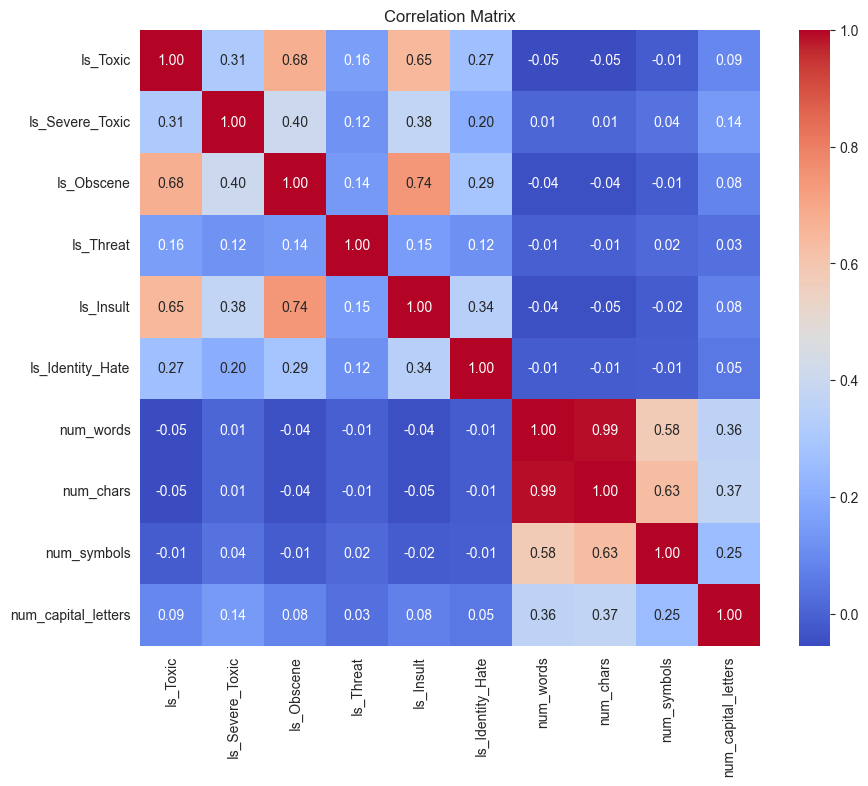

In [306]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Preprocessing

In [307]:
# Filter all hate comments for model training
hate_comments_df = (
    train_df[train_df[columns_type].any(axis=1)].copy().reset_index(drop=True)
)
print(f"Hate comments size: {len(hate_comments_df)}")

# Filter the same amount (or x2) of good comments for model training
good_comments_df = (
    train_df[train_df[columns_type].eq(0).all(axis=1)]
    .sample(n=GOOD_COMMENTS_RATIO * len(hate_comments_df), random_state=42)
    .copy()
    .reset_index(drop=True)
)
print(f"Good comments size: {len(good_comments_df)}")

# Concatenate 50% hate and 50% good comments and shuffle
train_df_copy = (
    pd.concat([hate_comments_df, good_comments_df], ignore_index=True)
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)
print(f"Final dataset size: {train_df_copy.shape}")

Hate comments size: 16225
Good comments size: 48675
Final dataset size: (64900, 8)


In [308]:
from src.preprocessing import do_preprocessing

train_df_copy["Comment_Text_Preprocessed"] = train_df_copy["Comment_Text"].apply(
    lambda d: " ".join(do_preprocessing(d))
)

In [309]:
X = train_df_copy["Comment_Text_Preprocessed"]
y = train_df_copy[columns_type]

tfidf_vectorizer = TfidfVectorizer(
    max_features=NUM_OF_FEATURES, max_df=0.9, smooth_idf=True, use_idf=True
)
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [310]:
# Save tfidf_vectorizer
joblib.dump(tfidf_vectorizer, "./models/tfidf_vectorizer.joblib")

# Load tfidf_vectorizer
# tfidf_vectorizer = joblib.load('./models/tfidf_vectorizer.joblib')

['./models/tfidf_vectorizer.joblib']

In [311]:
train_df_copy_tfidf = pd.concat([train_df_copy, tfidf_df], axis=1)
print(train_df_copy.shape)
print(train_df_copy_tfidf.shape)
print(f"Unique words count: {len(feature_names)}")

(64900, 9)
(64900, 5009)
Unique words count: 5000


In [312]:
# Display the top 100 most popular words
top_100_words = tfidf_df.sum().sort_values(ascending=False).head(100)
print(top_100_words.to_string())

article        1748.674411
page           1648.696378
talk           1232.264862
wikipedia      1108.705568
please         1107.600105
dont           1061.572716
like           1026.235995
one             895.425044
would           874.141510
im              851.173227
know            818.671045
fuck            811.894988
see             789.314545
think           781.109582
thanks          773.624508
edit            749.267147
get             735.643028
source          716.045339
people          673.499077
time            661.229981
also            648.188118
user            626.187005
go              622.448027
make            596.717743
want            562.133957
stop            559.371433
good            558.074762
need            550.382624
say             549.066391
comment         539.238080
youre           520.676288
link            519.422990
use             517.517090
editing         516.294799
name            512.458246
thank           510.891844
blocked         510.861672
l

In [313]:
# Check for any non-numeric values in the features dataframe
tfidf_features = train_df_copy_tfidf[feature_names]
numeric_df = tfidf_features.apply(pd.to_numeric, errors="coerce")
nan_values = numeric_df.isna().sum().sum()

if nan_values == 0:
    print("All values in the DataFrame are numeric.")
else:
    print(f"There are {nan_values} non-numeric values in the DataFrame.")

All values in the DataFrame are numeric.


# PCA

In [314]:
from sklearn.decomposition import PCA

n_components = 2
pca_2 = PCA(n_components=n_components)
pca_result_2 = pca_2.fit_transform(tfidf_features)
pca_result_df_2 = pd.DataFrame(
    data=pca_result_2, columns=[f"PCA_{i + 1}" for i in range(n_components)]
)

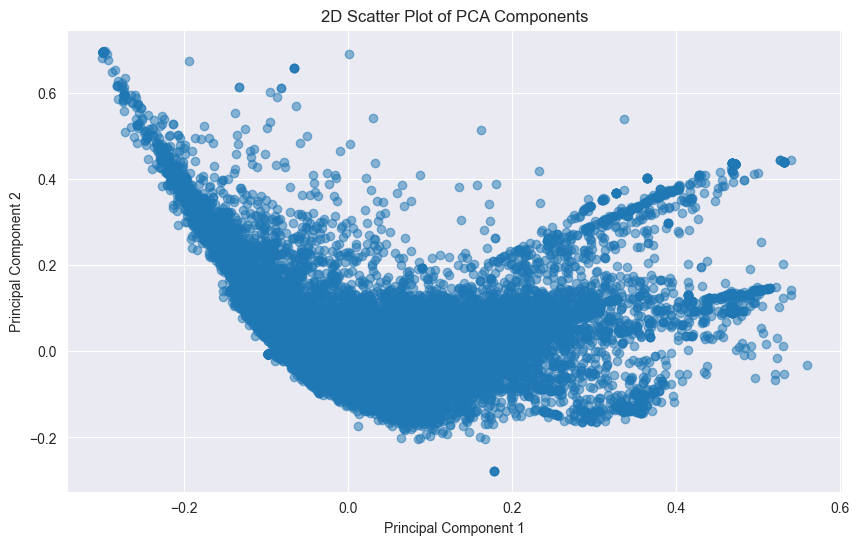

In [315]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_result_2[:, 0], pca_result_2[:, 1], alpha=0.5)
plt.title("2D Scatter Plot of PCA Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [316]:
print(pca_2.explained_variance_ratio_)

[0.00821414 0.00626919]


In [317]:
n_components = 3
pca_3 = PCA(n_components=n_components)
pca_result_3 = pca_3.fit_transform(tfidf_features)

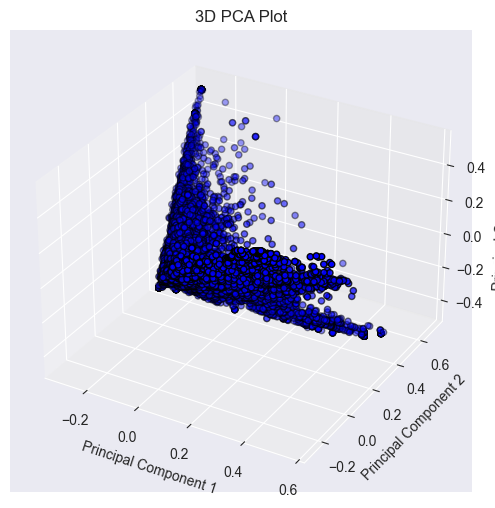

In [318]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    pca_result_3[:, 0],
    pca_result_3[:, 1],
    pca_result_3[:, 2],
    c="blue",
    marker="o",
    edgecolors="k",
)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Plot")
plt.show()

In [319]:
print(pca_3.explained_variance_ratio_)

[0.00821414 0.0062692  0.0053328 ]


In [320]:
if RUN_FULL_PCA:
    # Calculate PCA with 0.95 explained variance
    pca = PCA(0.95)
    pca_result = pca.fit_transform(tfidf_features)
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    plt.bar(
        range(0, len(exp_var_pca)),
        exp_var_pca,
        alpha=0.5,
        align="center",
        label="Individual explained variance",
    )
    plt.step(
        range(0, len(cum_sum_eigenvalues)),
        cum_sum_eigenvalues,
        where="mid",
        label="Cumulative explained variance",
    )
    plt.ylabel("Explained variance ratio")
    plt.xlabel("Principal component index")
    plt.legend(loc="best")
    plt.tight_layout()

    print(
        f"Number of components for 0.95 explained variance: {len(cum_sum_eigenvalues)}"
    )
    plt.show()

# Clustering

In [322]:
from sklearn.cluster import KMeans

n_clusters = 7

# Apply KMeans on UMAP data
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_result_2)
labels = kmeans_pca_labels

Number of clusters: 7
Cluster 0: 1725 points
Cluster 1: 13206 points
Cluster 2: 3609 points
Cluster 3: 536 points
Cluster 4: 979 points
Cluster 5: 34712 points
Cluster 6: 10133 points


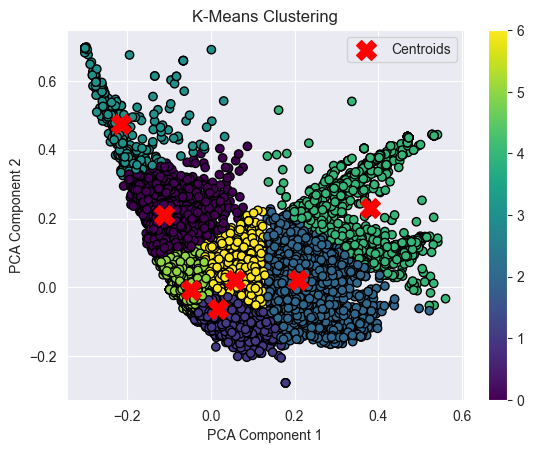

In [323]:
# Visualize the clustering results
scatter = plt.scatter(
    pca_result_2[:, 0],
    pca_result_2[:, 1],
    c=kmeans_pca_labels,
    cmap="viridis",
    marker="o",
    edgecolors="k",
)
plt.scatter(
    kmeans_pca.cluster_centers_[:, 0],
    kmeans_pca.cluster_centers_[:, 1],
    s=200,
    c="red",
    marker="X",
    label="Centroids",
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering")
plt.legend()

unique_labels = set(labels)
print("Number of clusters:", len(unique_labels) - (1 if -1 in unique_labels else 0))
for cluster_label in unique_labels:
    if cluster_label == -1:
        print(f"Noise points: {sum(labels == cluster_label)}")
    else:
        print(f"Cluster {cluster_label}: {sum(labels == cluster_label)} points")

plt.colorbar(scatter)
plt.show()

# Model Training

In [324]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, hamming_loss

In [325]:
X.head()

0    ehh misadventure back buddy biruitorul amusing...
1    simply say speaker must lying either part does...
2    please vandalize page edit melvin beederman se...
3                  hope fine request suggestion future
4                                        god damn sexy
Name: Comment_Text_Preprocessed, dtype: object

In [326]:
y.head()

,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,1,0,0,0


In [327]:
class_labels = ["Toxic", "Severe_Toxic", "Obscene", "Threat", "Insult", "Identity_Hate"]

In [328]:
# Split Dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101
)

X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [329]:
X_test_tfidf.shape

(12980, 5000)

In [330]:
if MODEL == LOGISTIC_REGRESSION:
    lr = LogisticRegression(max_iter=1000)
    clf = MultiOutputClassifier(lr)
    clf = clf.fit(X_train_tfidf, y_train)

In [331]:
if MODEL == LOGISTIC_REGRESSION:
    # Save model
    joblib.dump(clf, "./models/logistic_regression_classifier_model.joblib")
    # Load model
    # clf = joblib.load('./models/logistic_regression_classifier_model.joblib')

In [332]:
# Get the class labels for each classifier
# for i, estimator in enumerate(clf.estimators_):
#     print(f"Classifier {i + 1} Class Labels:", estimator.classes_)

In [333]:
# 0.663 - 0.078 x/x  10000 features
# 0.762 - 0.056 x/2x 10000 features
# 0.764 - 0.055 x/2x 5000 features
# 0.815 - 0.043 x/3x 5000 features
# 0.872 - 0.03  x/5x 5000 features
# Evaluate the model
if MODEL == LOGISTIC_REGRESSION:
    y_pred = clf.predict(X_test_tfidf)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    hamming = round(hamming_loss(y_test, y_pred), 3)
    classification_report_str = classification_report(y_test, y_pred, zero_division=1)
    print("Accuracy Score: ", accuracy)
    print("Hamming Loss: ", hamming)
    print("Classification Report:")
    print(classification_report_str)

Accuracy Score:  0.815
Hamming Loss:  0.043
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      3108
           1       0.51      0.23      0.32       311
           2       0.91      0.66      0.76      1722
           3       0.67      0.07      0.12        92
           4       0.82      0.56      0.67      1601
           5       0.76      0.24      0.36       285

   micro avg       0.88      0.62      0.72      7119
   macro avg       0.76      0.41      0.51      7119
weighted avg       0.86      0.62      0.71      7119
 samples avg       0.97      0.89      0.89      7119


In [334]:
if MODEL == LOGISTIC_REGRESSION:
    sample_text = ["some not very toxic toxic toxic text"]
    sample_text_tfidf = tfidf_vectorizer.transform(sample_text)
    sample_text_pred_prob = clf.predict_proba(sample_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = sample_text_pred_prob[i][:, 1]

In [335]:
if MODEL == LOGISTIC_REGRESSION:
    print(prediction_df)

      Toxic  Severe_Toxic   Obscene    Threat    Insult  Identity_Hate
0  0.048787      0.009648  0.026952  0.002925  0.030551       0.012945


In [336]:
if MODEL == RANDOM_FORREST:
    base_classifier = RandomForestClassifier(random_state=42)
    multi_output_classifier = MultiOutputClassifier(base_classifier)
    multi_output_classifier = multi_output_classifier.fit(X_train_tfidf, y_train)

In [337]:
if MODEL == RANDOM_FORREST:
    # Save model
    joblib.dump(
        multi_output_classifier, "./models/random_forrest_classifier_model.joblib"
    )
    # Load model
    # multi_output_classifier = joblib.load('./models/random_forrest_classifier_model.joblib')

In [338]:
# Evaluate the model
if MODEL == RANDOM_FORREST:
    y_pred = multi_output_classifier.predict(X_test_tfidf)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    hamming = round(hamming_loss(y_test, y_pred), 3)
    classification_report_str = classification_report(y_test, y_pred, zero_division=1)
    print("Accuracy Score: ", accuracy)
    print("Hamming Loss: ", hamming)
    print("Classification Report:")
    print(classification_report_str)

In [339]:
if MODEL == RANDOM_FORREST:
    prediction_probabilities = multi_output_classifier.predict_proba(X_test_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = prediction_probabilities[i][:, 1]

In [340]:
if MODEL == RANDOM_FORREST:
    print(prediction_df.head())

In [341]:
if MODEL == RANDOM_FORREST:
    sample_text = ["some toxic text"]
    sample_text_tfidf = tfidf_vectorizer.transform(sample_text)
    sample_text_pred_prob = multi_output_classifier.predict_proba(sample_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = sample_text_pred_prob[i][:, 1]

In [342]:
if MODEL == RANDOM_FORREST:
    print(prediction_df)

In [343]:
from sklearn.naive_bayes import MultinomialNB

if MODEL == MULTINOMIAL_NB:
    multinomial_nb = MultinomialNB(alpha=0.5, force_alpha=True)
    multinomial_classifier = MultiOutputClassifier(multinomial_nb)
    multinomial_classifier = multinomial_classifier.fit(X_train_tfidf, y_train)
    joblib.dump(multinomial_classifier, "./models/multinomial_nb.joblib")
    y_pred = multinomial_classifier.predict(X_test_tfidf)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    hamming = round(hamming_loss(y_test, y_pred), 3)
    classification_report_str = classification_report(y_test, y_pred, zero_division=1)
    print("Accuracy Score: ", accuracy)
    print("Hamming Loss: ", hamming)
    print("Classification Report:")
    print(classification_report_str)

# Prediction

In [344]:
columns_submission = [
    "id",
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate",
]

In [345]:
test_df.head()

,ID,Comment_Text
0,0001ea8717f6de06,Thank you for understanding. I think very high...
1,000247e83dcc1211,:Dear god this site is horrible.
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


In [346]:
# Good comment
test_df.loc[test_df["ID"] == "00177176f33f587e"]

,ID,Comment_Text
28,00177176f33f587e,== Can you work your magic? == \n\n Hi. I was...


In [347]:
# Bad comment
test_df.loc[test_df["ID"] == "0013fed3aeae76b7"]

,ID,Comment_Text
24,0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...


In [348]:
test_text_tfidf = tfidf_vectorizer.transform(test_df["Comment_Text"])

In [349]:
if MODEL == LOGISTIC_REGRESSION:
    test_text_tfidf_prob = clf.predict_proba(test_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = test_text_tfidf_prob[i][:, 1]

In [350]:
if MODEL == LOGISTIC_REGRESSION:
    result_df = pd.concat([test_df["ID"], prediction_df], axis=1)
    result_df.columns = columns_submission
    result_df.to_csv("../output/submission.csv", index=False)
    result_df.head()

In [351]:
if MODEL == RANDOM_FORREST:
    test_text_tfidf_prob = multi_output_classifier.predict_proba(test_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = test_text_tfidf_prob[i][:, 1]

In [352]:
if MODEL == RANDOM_FORREST:
    result_df = pd.concat([test_df["ID"], prediction_df], axis=1)
    result_df.columns = columns_submission
    result_df.to_csv("../output/submission_random_forrest.csv", index=False)
    result_df.head()

In [353]:
if MODEL == MULTINOMIAL_NB:
    test_text_tfidf_prob = multinomial_classifier.predict_proba(test_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = test_text_tfidf_prob[i][:, 1]

In [354]:
if MODEL == MULTINOMIAL_NB:
    result_df = pd.concat([test_df["ID"], prediction_df], axis=1)
    result_df.columns = columns_submission
    result_df.to_csv("../output/submission_multinomial.csv", index=False)
    result_df.head()